In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [2]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")

PyTorch version: 2.6.0
MPS available: True


# Building a Generative Diffusion Model with MNIST

## Project Objectives

In this notebook, I'll document the process of building a generative diffusion model that can recreate numbers from the MNIST dataset.

This implementation uses a simple DDPM (Denoising Diffusion Probabilistic Model) approach. The model exclusively removes noise based on random input noise images, without any conditioning or optimizations. In fact, it's entirely unoptimized for running on my laptop's limited hardware, so this notebook is really a learning exercise to help me understand the fundamentals of diffusion models.

## Process Overview

<img src="assets/Diffusion%20Model%20Pytorch.webp" alt="Diffusion Model PyTorch" style="width:700px; height:auto;"><br>
<i>(['Understanding Deep Learning'](https://mitpress.mit.edu/9780262048644/understanding-deep-learning/) by Simon J.D. Prince via ['Diffusion Model from Scratch in Pytorch'](https://towardsdatascience.com/diffusion-model-from-scratch-in-pytorch-ddpm-9d9760528946/) by Nicholas DiSalvo)</i>

Diffusion models work by gradually adding noise to images (forward process) and then learning to reverse this process (reverse process), allowing for high-quality image generation.

The forward process is a predetermined 'Markov chain' based on a noise schedule. Whereby; "predetermined" means we decide in advance exactly how much noise to add at each step according to our noise schedule - it's not random but follows a specific pattern, and "Markov chain" means each noisy version only depends on the previous step - like a chain where each link only connects to the ones right next to it. When you combine these concepts, you can precisely calculate how noisy an image will be at any step in the process, setting the stage for a model to learn how to remove the noise that has been added.

<img src="assets/unet-model-diagram.webp" alt="Unet Model" style="width:500px; height:auto;"><br>
<i>(UNET for Diffusion by [Nicholas DiSalvo](https://towardsdatascience.com/author/nickd16718/))</i>

A U-Net architecture is trained to predict the noise that was added at any arbitrary timestep, by taking a noisy image at a specific timestep and trying to predict what noise was added to it.<br>The U-Net architecture itself, with its downsampling path (reduces spatial dimensions) and upsampling (increases spatial dimensions) path connected by skip connections, is particularly good at this task because:

- The downsampling captures the overall structure and context
- The upsampling reconstructs detailed features
- The skip connections help preserve important information from earlier layers

It could be optimised with scoring or conditional inputs, but we're keeping things simple for now.

## Dataset Information

For this project, I'm using the "CleanIcons-MechagnomeEdition" dataset, specifically version 11.1.0.59347-V4-1, which contains a collection of World of Warcraft icons (upscaled by Mechagnome).
This dataset provides a foundation for exploring diffusion model training on stylistically consistent gaming assets - It may genuinely not work at all, but let's see...

### Dataset Details

- **Name**: CleanIcons-MechagnomeEdition-11.1.0.59347-V4-1
- **Source**: [GitHub - AcidWeb/Clean-Icons-Mechagnome-Edition](https://github.com/AcidWeb/Clean-Icons-Mechagnome-Edition/releases/tag/11.1.0.59347-V4-1)
- **Contents**: World of Warcraft icons
- **Format**: TGA (Truevision Graphics Adapter) image files
- **Features**: High-quality game icons with transparency support

### Implementation Notes

This implementation adapts the diffusion model architecture to work with:

- TGA format images (using PIL for loading)
- Apple Silicon hardware (ensuring MPS device compatibility)
- Custom data loading pipeline for WoW icon processing

### Credits and References

This implementation takes direct reference from ["A Diffusion Model from Scratch in PyTorch"](https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=Rj17psVw7Shg).

The original work references:

- GitHub implementation of [Denoising Diffusion PyTorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Work by Niels Rogge and Kashif Rasul in their [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Academic papers on Diffusion models:
  - [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672) (Nichol & Dhariwal, 2021)
  - [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) (Ho et al., 2020)
  - [Diffusion Models Beat GANs on Image Synthesis](https://arxiv.org/abs/2105.05233) (Dhariwal & Nichol, 2021)

I've adapted this implementation to work specifically with TGA format WoW icons on Apple Silicon hardware, modifying the data loading pipeline and ensuring MPS device compatibility.


In [3]:
from torchvision import datasets, transforms

# Load MNIST dataset

# Define transformations for MNIST dataset
data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert image to tensor (0,1)
        transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1,1]
    ]
)


data_dir = "./data/"
data = datasets.MNIST(
    root=data_dir, train=True, transform=data_transforms, download=True
)

In [4]:
# Functions to read Image & Label from given file path
def read_idx_images(file_path):
    """Reads an IDX image file and returns a tensor of shape (N, 28, 28)"""
    with open(file_path, "rb") as f:
        f.read(4)  # Skip magic number
        num_images = int.from_bytes(f.read(4), "big")
        rows = int.from_bytes(f.read(4), "big")
        cols = int.from_bytes(f.read(4), "big")
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
        return torch.tensor(data, dtype=torch.float32)  # Convert to float


def read_idx_labels(file_path):
    """Reads an IDX label file and returns a tensor of shape (N,)"""
    with open(file_path, "rb") as f:
        f.read(4)  # Skip magic number
        num_labels = int.from_bytes(f.read(4), "big")
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return torch.tensor(data, dtype=torch.long)  # Convert to long tensor

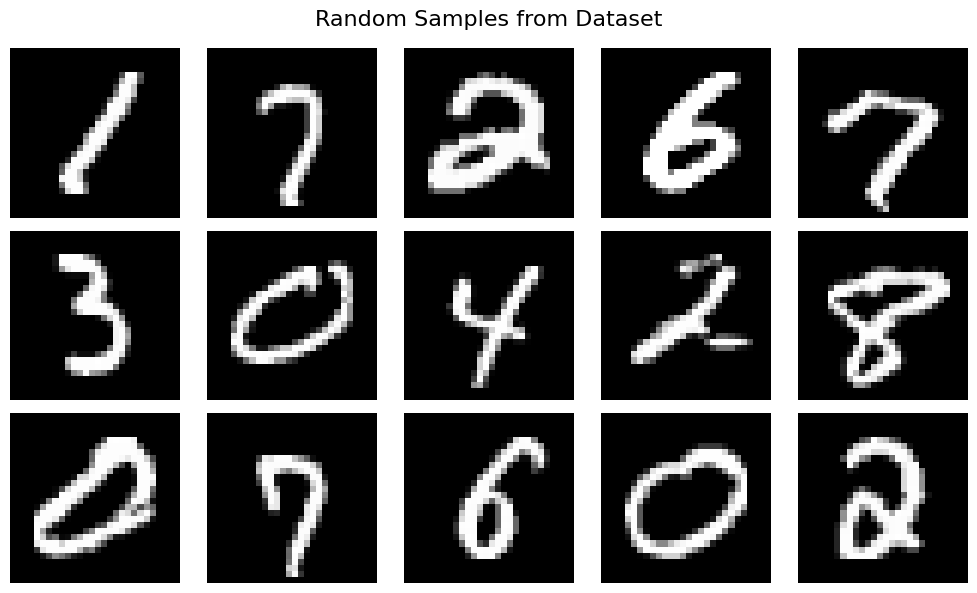

In [5]:
# Assuming read_idx_images loads a tensor of shape (N, 28, 28)
dataset_root_path = "./data/MNIST/raw/t10k-images-idx3-ubyte"
dataset = read_idx_images(dataset_root_path)  # Should return a (N, 28, 28) tensor

# Select 15 random indices
num_samples = 15
random_indices = torch.randint(0, len(dataset), (num_samples,))  # Random indices
dataset_sample = dataset[random_indices]  # Get the images

# Display the images
fig = plt.figure(figsize=(10, 6))

for i, image in enumerate(dataset_sample):
    plt.subplot(3, 5, i + 1)  # Use 3x5 grid
    plt.imshow(image.numpy(), cmap="gray")  # Convert tensor to NumPy
    plt.axis("off")

fig.suptitle("Random Samples from Dataset", fontsize=16)
plt.tight_layout()
plt.show()

## Forward Diffusion Process Explained

The forward diffusion process gradually adds noise to an image over a series of timesteps. Let's break down the key components:

### Noise Schedule Function

```python
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)
```

This function creates a linear schedule for the noise variance (β) at each timestep:

- Starts with minimal noise (`start=0.0001`)
- Gradually increases to larger noise (`end=0.02`)
- Creates `timesteps` evenly spaced values
- The schedule controls how quickly information is destroyed during diffusion

### Helper Function for Batch Processing

```python
def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
```

This utility function:

- Extracts specific values from a parameter tensor based on timestep indices
- Reshapes the output to properly broadcast across the image dimensions
- Ensures values are on the correct device for computation
- Enables efficient batch processing of images at different timesteps

### Forward Diffusion Function

```python
def forward_diffusion_sample(x_0, t, device="mps"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(
        device
    ) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)
```

This implements the core diffusion equation from Ho et al. (2020):

$$q(x_t|x_0) = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1-\bar{\alpha}_t} \cdot \epsilon$$

Where:

- $x_0$ is the original image
- $x_t$ is the noisy image at timestep $t$
- $\epsilon$ is random Gaussian noise
- $\bar{\alpha}_t$ represents how much of the original signal remains at timestep $t$

### Pre-calculated Diffusion Parameters

```python
# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
```

These calculations:

- Set up the full noise schedule for all timesteps
- Pre-compute constants needed for both forward diffusion and the eventual reverse process
- Define how the signal-to-noise ratio changes at each step of the diffusion
- Calculate the posterior variance needed for the sampling process

The mathematical setup follows the DDPM paper (Ho et al., 2020), where:

- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i$

These pre-calculations allow for efficient training and sampling as we don't need to recompute these values repeatedly.


In [6]:
import torch.nn.functional as F


def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Creates a linear schedule for the noise variance (β) at each timestep:

    timesteps: the number of timesteps
    start: the starting value of the schedule
    end: the ending value of the schedule
    """
    return torch.linspace(start, end, timesteps)


def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.

    vals: the list of values to get the index from
    t: the timestep
    x_shape: the shape of the input
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def forward_diffusion_sample(x_0, t, device="mps"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it

    x_0: the original image
    t: the timestep
    device: the device to run the computation on
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(
        device
    ) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

## Dataset and Data Loading Pipeline

This section sets up the data loading pipeline for our WoW icons dataset. <br>
It handles loading the TGA image files, preprocessing them, and creating batches for training.


Using device: mps


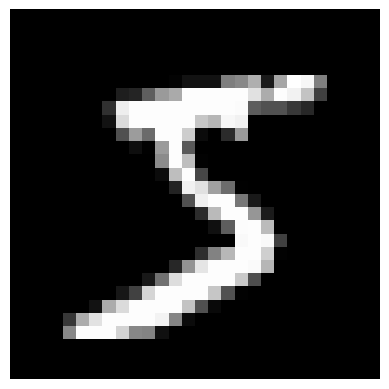

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch

# Check for MPS availability
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

IMG_SIZE = 28  # MNIST images are 28x28
BATCH_SIZE = 256

# Define transformations for MNIST dataset
data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert image to tensor (0,1)
        transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1,1]
    ]
)

# Configure DataLoader
dataloader = DataLoader(
    data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=0,  # Avoid pickle issues with multiple workers
)


# Function to show a single tensor image
def show_tensor_image(image):
    """
    Display a tensor as an image
    """
    # Remove batch dimension
    if len(image.shape) == 4:  # [B, C, H, W]
        image = image.squeeze(0)  # → [C, H, W]

    # For grayscale (MNIST) images
    if image.shape[0] == 1:  # [1, H, W]
        image = image.squeeze(0)  # → [H, W]

    # Scale from [-1, 1] to [0, 1]
    image = (image + 1) / 2

    # Convert to numpy for display
    image_np = image.numpy()

    # Display as grayscale
    plt.imshow(image_np, cmap="gray")
    plt.axis("off")


# Function to move batch to device efficiently
def prepare_batch(batch, target_device=device):
    return batch[0].to(target_device)  # Only move image tensors (ignore labels)


# Test: Display a sample image from the dataset
sample_image, _ = data[0]  # Get first image
show_tensor_image(sample_image)

## Forward Diffusion Demo

This visualization displays the forward diffusion process applied to our WoW icons. Each row shows a different randomly selected icon from the dataset, while columns represent progressive timesteps in the diffusion process.<br><br>
Moving from left to right along each row, you see how the diffusion model gradually adds more noise to the original clean images. The leftmost column shows the original, unmodified WoW icons in their clean state. As you move right, each subsequent image shows the same icon with increasing amounts of random noise applied according to a carefully controlled schedule (T=300).<br><br>
By the rightmost column, the icons have been almost completely transformed into pure noise, with little to no recognizable features remaining from the original images. This visual demonstration illustrates how the forward diffusion process systematically destroys information in the original images over time.<br><br>
Understanding this forward process is crucial because training a diffusion model involves teaching a neural network to reverse this exact process - starting from pure noise and progressively removing it to generate new, realistic WoW icons.


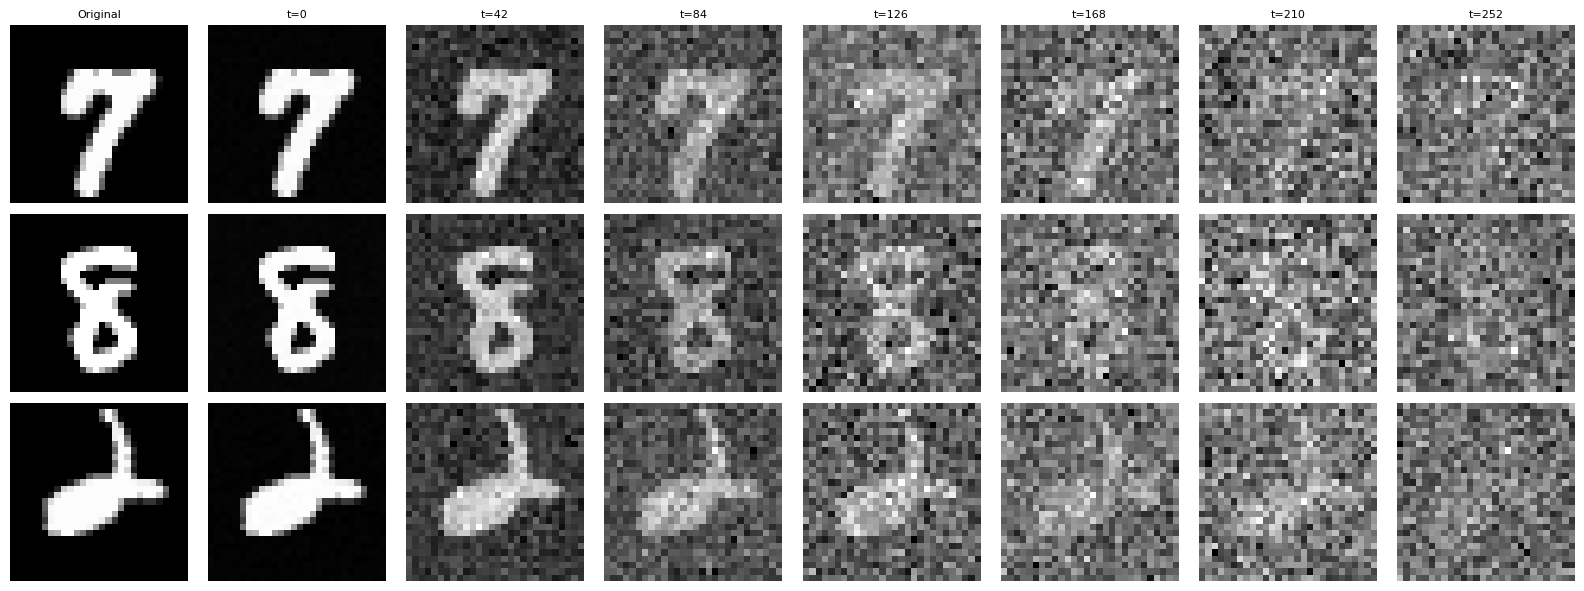

In [8]:
def display_images_with_diffusion(
    dataloader, num_images=3, num_steps=7, T=300, device="mps"
):
    """
    Display a grid of randomly selected images with the diffusion process applied.
    Each row shows one icon progressively diffused with noise from left to right.
    The first column shows the original, unmodified icon.

    Args:
        dataloader: PyTorch dataloader containing the dataset
        num_images: Number of different images to display (rows)
        num_steps: Number of diffusion steps to display (not including original)
        T: Total number of timesteps in the diffusion process
        device: Device to run computations on
    """
    # Get a batch of images
    batch = next(iter(dataloader))

    # Move batch to device
    batch = prepare_batch(batch, device)

    # Create figure
    fig, axes = plt.subplots(
        num_images, num_steps + 1, figsize=((num_steps + 1) * 2, num_images * 2)
    )

    # Get random indices from the batch
    batch_size = batch.shape[0]
    indices = np.random.choice(batch_size, size=num_images, replace=False)

    # Calculate the step size between diffusion steps
    stepsize = int(T / num_steps)

    # Plot each selected image with different noise levels
    for row, idx in enumerate(indices):
        # Get the original image
        original_img = batch[idx].unsqueeze(0)  # Add batch dimension
        original_display = original_img.squeeze(0)  # Ensure shape is (H, W)

        # First, display the original image with no noise
        ax = axes[row, 0]  # First column
        ax.imshow(original_display.squeeze(0).cpu().numpy(), cmap="gray")
        ax.axis("off")

        if row == 0:
            ax.set_title("Original", fontsize=8)

        # Apply different levels of noise for the remaining columns
        for col, timestep in enumerate(range(0, T, stepsize)):
            if col >= num_steps:
                break

            ax = axes[row, col + 1]  # Remaining columns
            ax.axis("off")

            # Apply forward diffusion with current timestep
            t = torch.tensor([timestep], device=device).type(torch.int64)
            noisy_img, _ = forward_diffusion_sample(original_img, t, device=device)
            noisy_img = noisy_img.squeeze().cpu().numpy()  # Ensure shape is (H, W)

            # Display the image
            ax.imshow(noisy_img, cmap="gray")

            # Add timestep as title for the first row
            if row == 0:
                ax.set_title(f"t={timestep}", fontsize=8)

    plt.tight_layout()
    plt.show()


# Usage example
display_images_with_diffusion(dataloader, num_images=3, num_steps=7, T=300)

## The Reverse Diffusion Process and U-Net Architecture

While the forward diffusion process gradually adds noise to images, the reverse diffusion process is where the magic bits happens - <br>It's how we generate new images by progressively removing noise. This is accomplished using a neural network (in our case, a U-Net) that predicts the noise component at each timestep.

### The Reverse Diffusion Equation

The diffusion model learns to reverse the forward process by predicting the noise ε that was added at each timestep. The mathematical equation for the reverse process is:

$$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

Where:

- $p_\theta$ is our model's reverse distribution
- $\mu_\theta$ is the predicted mean
- $\Sigma_\theta$ is the predicted variance

Instead of trying to learn how to generate images directly (which is very hard), the neural network (U-Net) is trained on a simpler task: "Given an image with noise at step t, can you predict what noise was added?". Once the network is trained to predict noise accurately, we can use it to generate brand new images by starting with pure random noise and then iteratively "removing" the predicted noise.

### U-Net Architecture Overview

A U-Net is a specific type of neural network architecture that was originally developed for biomedical image segmentation but has become widely used across many image processing tasks, including diffusion models.
The mechanism that makes U-Net effective for both medical image segmentation and diffusion models comes down to some key architectural properties that transfer well between these seemingly different tasks:

- <b>Preserving spatial relationships</b>: In medical imaging, U-Net excels at identifying boundaries and structures while maintaining their spatial relationships. In diffusion models, this same ability helps preserve the underlying structure of an image while noise is being predicted or removed.
- <b>Multi-scale feature processing</b>: Medical images often contain features at different scales (from tiny cell structures to larger organs). Similarly, noise in diffusion models affects features at multiple scales - from fine textures to broader shapes. The U-Net's downsampling/upsampling path <i>(reducing/increasing the spatial dimensions of an image or feature map.)</i> processes information at various resolutions, making it effective for both tasks.
- <b>Context integration with precision</b>: For medical segmentation, U-Net combines broad contextual information (Is this a liver? A brain?) with precise boundaries. For diffusion, it balances understanding the overall image structure while precisely identifying noise patterns at each pixel location.
- <b>Transformation precision</b>: Both tasks require pixel-level precision in predicting output images. Whether defining the exact boundary of a tumor or determining exactly how much noise is at each pixel location, the U-Net's architecture is designed for this precise image-to-image mapping.
- <b>Skip connections</b>: In a U-Net, a 'skip connection' directly connects a layer in the downsampling path to its corresponding layer in the upsampling path. For example, the features from the first downsampling layer are connected to the last upsampling layer, the second downsampling layer to the second-to-last upsampling layer, and so on. Skip connections solve a fundamental problem in deep networks: a) The downsampling path is great for capturing context but loses spatial precision b) The upsampling path needs to reconstruct spatial details but starts from compressed information
  - In medical imaging: They help preserve fine boundary details that would be lost in downsampling
  - In diffusion models: They help the model maintain the underlying image structure while focusing on noise prediction

The fundamental similarity is that both tasks involve transforming one image into another while preserving important structural information - whether that's transforming a medical scan into a segmentation map or transforming a noisy image into a noise prediction (which then allows for denoising).

Our implementation uses a simplified U-Net with:

- A downsampling path that reduces spatial dimensions and increases feature channels
- An upsampling path that increases spatial dimensions and decreases feature channels
- Skip connections that concatenate features from the downsampling path to the upsampling path
- Time embeddings that inform the network which diffusion timestep it's operating on

### Time Embeddings

A critical aspect of diffusion models is that the network needs to know which timestep it's denoising. We use sinusoidal position embeddings, similar to those in transformer architectures:

```python
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
```

These embeddings create unique representations for each timestep that the model can use to apply the appropriate amount of denoising.

### Building Blocks

The `Block` class forms the foundation of both the downsampling and upsampling paths:

```python
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
```

Each block:

- Takes in a feature map and timestep embedding
- Processes the feature map with convolutions and nonlinearities
- Injects the timestep information via addition
- Either downsamples (using strided convolution) or upsamples (using transposed convolution)

### Complete U-Net Architecture

The `SimpleUnet` class brings everything together:

```python
class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)
```

The network:

1. Takes an image and timestep as input
2. Embeds the timestep using sinusoidal embeddings
3. Processes the image through a series of downsampling blocks, reducing spatial dimensions and capturing increasingly abstract features
4. Processes through upsampling blocks, gradually increasing spatial dimensions while incorporating features from the corresponding downsampling blocks via skip connections
5. Produces an output with the same spatial dimensions and channels as the input image, representing the predicted noise

### Training Objective

The model is trained to predict the noise that was added during the forward diffusion process. The loss function is simply the mean squared error between the predicted noise and the actual noise:

$$L = \mathbb{E}_{t,x_0,\epsilon}[||\epsilon - \epsilon_\theta(x_t, t)||^2]$$

Where:

- $\epsilon$ is the actual noise added
- $\epsilon_\theta$ is the model's prediction of the noise
- $x_t$ is the noisy image at timestep $t$

By minimizing this loss, the model learns to estimate the noise component at any given timestep, which is the key to generating new images through the reverse diffusion process.


In [9]:
import torch
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        # Replace BatchNorm with GroupNorm which works with any batch size
        self.norm1 = nn.GroupNorm(8, out_ch)  # 8 groups is a good default
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        h = self.norm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(...,) + (None,) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.norm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture for M1 Pro compatibility.
    """

    def __init__(self, device="mps"):
        super().__init__()
        self.device = device
        image_channels = 1
        # Reduce the number of downsampling layers to prevent spatial dimensions from becoming too small
        down_channels = (64, 128, 256, 512)  # Removed the last 1024 layer
        up_channels = (512, 256, 128, 64)  # Adjusted accordingly
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList(
            [
                Block(down_channels[i], down_channels[i + 1], time_emb_dim)
                for i in range(len(down_channels) - 1)
            ]
        )
        # Upsample
        self.ups = nn.ModuleList(
            [
                Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True)
                for i in range(len(up_channels) - 1)
            ]
        )

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

        # Move model to appropriate device
        self.to(device)

    def forward(self, x, timestep):
        # Ensure inputs are on the correct device
        x = x.to(self.device)
        timestep = timestep.to(self.device)

        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        for up in self.ups:
            residual_x = residual_inputs.pop()

            # Add this check to ensure tensors have compatible spatial dimensions
            if x.shape[2:] != residual_x.shape[2:]:
                # Resize x to match residual_x's spatial dimensions
                x = nn.functional.interpolate(
                    x, size=residual_x.shape[2:], mode="bilinear", align_corners=False
                )

            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)


def get_loss(model, x_0, t, device="mps"):
    """
    Calculates training loss for a batch of images at specified timesteps.
    """
    x_0 = x_0.to(device)
    t = t.to(device)

    # Get noise
    noise = torch.randn_like(x_0).to(device)

    # Get noisy image at timestep t
    x_noisy, _ = forward_diffusion_sample(x_0, t, device)

    # Get predicted noise from model
    noise_pred = model(x_noisy, t)

    # Calculate loss (mean squared error between actual and predicted noise)
    loss = F.mse_loss(noise, noise_pred)

    return loss


# Initialize model
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = SimpleUnet(device=device)
print(f"Using device: {device}")
print(f"Num params: {sum(p.numel() for p in model.parameters())}")

# Setup optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Using device: mps
Num params: 15452385


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): GroupNorm(8, 128, eps=1e-05, affine=True)
      (norm2): GroupNorm(8, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (c

## Loss Function

"Loss" refers to a mathematical measure of how well your diffusion model is performing.
It quantifies the error or difference between what your model predicts and the actual target values.
<br>For your diffusion model specifically:

1. You start with a clean image (a WoW icon)
2. You add a known amount of random noise to it
3. You ask your model to predict what noise was added
4. The "loss" measures how far off your model's prediction is from the actual noise that was added

The F.l1_loss() function calculates the Mean Absolute Error (MAE), which is the average of the absolute differences between the predicted noise and the actual noise. A smaller loss value means your model is doing a better job at predicting the noise.<br>
During training, your optimization algorithm (like Adam) uses this loss value to update the model's parameters, gradually improving its ability to predict the noise. The goal is to minimize this loss over many training iterations.<br>
Once the model is trained to accurately predict the noise at each timestep, you can use it in reverse - starting with pure noise and gradually removing the predicted noise components to generate new WoW icons that never existed before.


In [10]:
def get_loss(model, x_0, t):
    """
    Calculates training loss for a batch of images at specified timesteps.
    Handles channel dimension mismatch between noise and model output.
    """
    # Create a noisy version of the original image at timestep t
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)

    # Use the model to predict what noise was added
    noise_pred = model(x_noisy, t)

    # Adjust noise channels to match prediction channels if needed
    if noise.shape[1] != noise_pred.shape[1]:
        # Keep only the first 3 channels of noise to match noise_pred
        noise = noise[:, : noise_pred.shape[1], :, :]

    # Calculate the L1 loss (mean absolute error) between
    # the actual noise and the predicted noise
    return F.l1_loss(noise, noise_pred)

## Sampling

### Key Implementation Details

- These functions implement the sampling/generation process for creating new images with our diffusion model.

- **Memory Management**: Without adding `@torch.no_grad()` we quickly run out of memory, because PyTorch tracks all the previous images for gradient calculation. When you use `@torch.no_grad()` as a decorator for your sampling functions, you're telling PyTorch not to track operations for automatic differentiation (gradients).

- **Noise Schedule Consistency**: During the reverse process (image generation), we need to know exactly how much noise to remove at each step. For this to work properly, we need to use the same noise schedule that we used when adding noise. It's like following a recipe in reverse - you need to know the exact amounts that were added originally to remove them correctly.

### Benefits of Pre-calculated Values

The pre-calculated values ensure that:

1. We're removing the right amount of noise at each step
2. We're adding the right amount of new randomness when needed (yes, sometimes we add a small amount of new noise during generation)

If we didn't use these pre-calculated values and instead made up new values during the reverse process, the math wouldn't work out correctly, and we'd get blurry or unrealistic images.


In [11]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    This function performs a single step of the reverse diffusion process,
    taking a noisy image and making it slightly less noisy.
    Calls the model to predict the noise in the image and returns
    the denoised image. Applies noise to this image, if we are not in the last step yet.

        1. Gets the appropriate noise parameters for the current timestep
        2. Uses your trained model to predict what noise is present in the current noisy image
        3. Uses that prediction to calculate a cleaner version of the image
        4. If we're not at the final step, adds a small amount of new random noise (helps with sample quality)
        5. Returns the slightly cleaner image
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Get model prediction (the model outputs only 3 channels)
    model_output = model(x, t)

    # Handle channel mismatch: pad model output to match input if needed
    if model_output.shape[1] != x.shape[1]:
        # Create a tensor of zeros with the same shape as x
        padded_output = torch.zeros_like(x)
        # Copy the available channels from model_output
        padded_output[:, : model_output.shape[1]] = model_output
        model_output = padded_output

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model_output / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def sample_plot_image():
    """
    This function generates a completely new image by iteratively applying
    the sampling process and visualizing the intermediate steps.
        1. Starts with completely random noise (a new "seed" image)
        2. Sets up a figure to display the generation process
        3. Iterates through all timesteps in reverse order (from T down to 0)
        4. At each step, calls sample_timestep to make the image a bit cleaner
        5. Clamps the pixel values to keep them in the valid range
        6. Periodically visualizes the current state to show the progressive denoising
    """
    # Sample noise with 4 channels to match model's expected input
    img_size = IMG_SIZE
    img = torch.randn(
        (1, 1, img_size, img_size), device=device
    )  # Changed from 3 to 4 channels

    plt.figure(figsize=(15, 2))
    plt.axis("off")
    num_images = 10
    stepsize = int(T / num_images)

    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i / stepsize) + 1)
            # For MNIST, we only have 1 channel, so no need to select channels for display
            show_tensor_image(img.detach().cpu())
    plt.show()

Using MPS
Epoch 0 of 75
Epoch 0 | step 000 Loss: 0.8075439929962158 


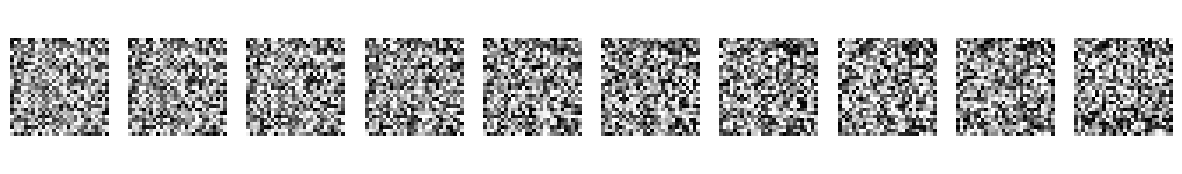

Epoch 1 of 75
Epoch 2 of 75
Epoch 3 of 75
Epoch 4 of 75
Epoch 5 of 75
Epoch 6 of 75
Epoch 7 of 75
Epoch 8 of 75
Epoch 9 of 75
Epoch 10 of 75
Epoch 11 of 75
Epoch 12 of 75
Epoch 13 of 75
Epoch 14 of 75
Epoch 15 of 75
Epoch 15 | step 000 Loss: 0.08101362735033035 


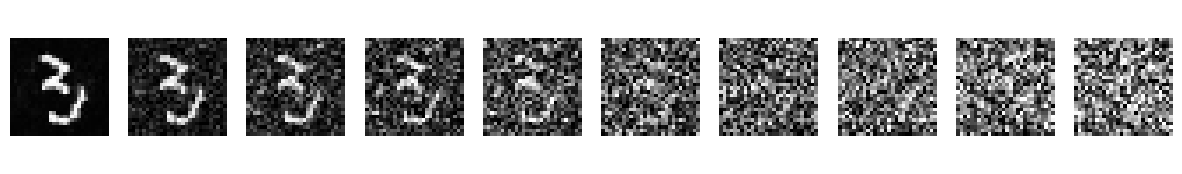

Epoch 16 of 75
Epoch 17 of 75
Epoch 18 of 75
Epoch 19 of 75
Epoch 20 of 75
Epoch 21 of 75
Epoch 22 of 75
Epoch 23 of 75
Epoch 24 of 75
Epoch 25 of 75
Epoch 26 of 75
Epoch 27 of 75
Epoch 28 of 75
Epoch 29 of 75
Epoch 30 of 75
Epoch 30 | step 000 Loss: 0.07319651544094086 


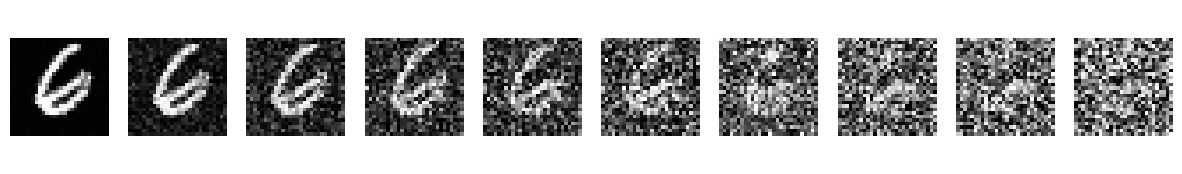

Epoch 31 of 75
Epoch 32 of 75
Epoch 33 of 75
Epoch 34 of 75
Epoch 35 of 75
Epoch 36 of 75
Epoch 37 of 75
Epoch 38 of 75
Epoch 39 of 75
Epoch 40 of 75
Epoch 41 of 75
Epoch 42 of 75
Epoch 43 of 75
Epoch 44 of 75
Epoch 45 of 75
Epoch 45 | step 000 Loss: 0.07343706488609314 


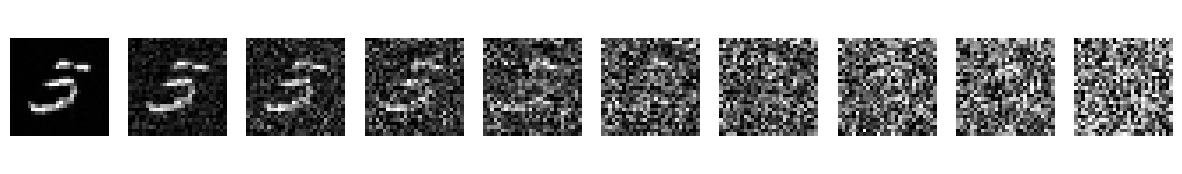

Epoch 46 of 75
Epoch 47 of 75
Epoch 48 of 75
Epoch 49 of 75
Epoch 50 of 75
Epoch 51 of 75
Epoch 52 of 75
Epoch 53 of 75
Epoch 54 of 75
Epoch 55 of 75
Epoch 56 of 75
Epoch 57 of 75
Epoch 58 of 75
Epoch 59 of 75
Epoch 60 of 75
Epoch 60 | step 000 Loss: 0.07400940358638763 


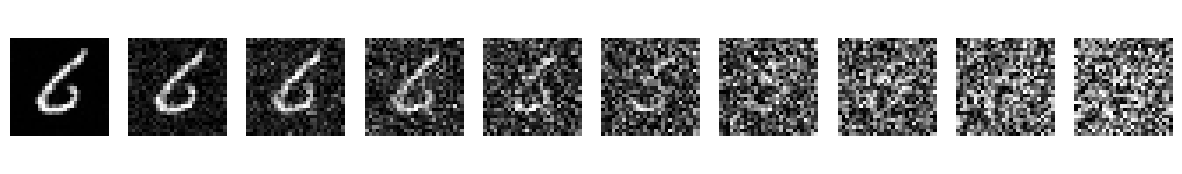

Epoch 61 of 75
Epoch 62 of 75
Epoch 63 of 75
Epoch 64 of 75
Epoch 65 of 75
Epoch 66 of 75
Epoch 67 of 75
Epoch 68 of 75
Epoch 69 of 75
Epoch 70 of 75
Epoch 71 of 75
Epoch 72 of 75
Epoch 73 of 75
Epoch 74 of 75


In [12]:
from torch.optim import Adam

# Check for MPS (Metal Performance Shaders) for Mac with Apple Silicon
if torch.backends.mps.is_available():
    device = "mps"
    print("Using MPS")
elif torch.cuda.is_available():
    device = "cuda"
    print("Using CUDA")
else:
    device = "cpu"
    print("Using CPU")

model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 75  # Try more!

for epoch in range(epochs):
    print(f"Epoch {epoch} of {epochs}")

    # iterate over the dataloader
    for step, batch in enumerate(dataloader):
        # if step % 25 == 0:
        #     print(f"Step {step} of {len(dataloader)}")
        optimizer.zero_grad()

        img_tensor = batch[0]
        label_tensor = batch[1]

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, img_tensor, t)
        loss.backward()
        optimizer.step()

        if epoch % 15 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()

In [14]:
# Save the model
torch.save(model.state_dict(), "MNIST_diffusion_model.pth")

# IT WORKS !! 🎉


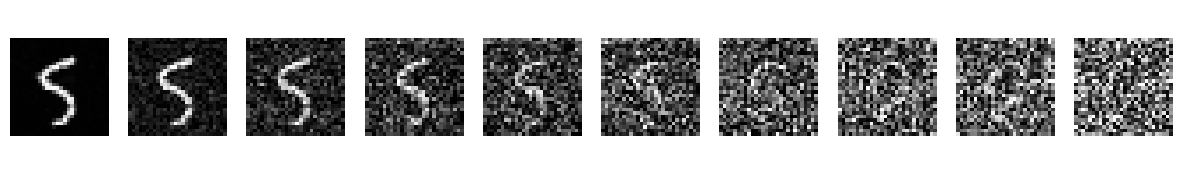

In [17]:
sample_plot_image()

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import os


@torch.no_grad()
def create_diffusion_video(
    filename="diffusion_video.mp4", fps=30, dpi=150, show_every=1, grid=None
):
    """
    Creates a video showing the diffusion process from noise to coherent image.
    Optionally arranges multiple diffusion processes in a grid layout.

    Args:
        filename: Output video filename (should end with .mp4)
        fps: Frames per second in the output video
        dpi: Resolution of the output video
        show_every: Only include every Nth step (to reduce video size)
        grid: Optional tuple (rows, cols) to create a grid of diffusion processes.
              If None, creates a single video.

    Returns:
        Path to the saved video file
    """
    # Determine if we're making a grid or single video
    if grid is None:
        rows, cols = 1, 1
    else:
        rows, cols = grid

    # Set up figure with the right size and layout
    if rows == 1 and cols == 1:
        fig, axes = plt.subplots(figsize=(6, 7))  # Extra height for the title
        axes = np.array([[axes]])  # Make it a 2D array for consistent indexing
    else:
        fig, axes = plt.subplots(
            rows, cols, figsize=(cols * 3, rows * 3 + 1)
        )  # Extra height for the title
        if rows == 1:
            axes = axes.reshape(1, cols)
        elif cols == 1:
            axes = axes.reshape(rows, 1)

    # Remove ticks from all subplots
    for r in range(rows):
        for c in range(cols):
            axes[r, c].set_xticks([])
            axes[r, c].set_yticks([])

    # Add adequate padding to make room for the title
    plt.subplots_adjust(top=0.85)  # Move subplots down to make room for title

    # Start with random noise for each grid position
    img_size = IMG_SIZE
    grid_images = []
    for r in range(rows):
        for c in range(cols):
            # Create a random seed image
            img = torch.randn((1, 1, img_size, img_size), device=device)
            grid_images.append(img)

    # Store all frames for the animation
    all_frames = []

    print(
        f"Generating {T//show_every} frames for {'single image' if grid is None else f'{rows}x{cols} grid'}..."
    )

    # Run the reverse diffusion process for all images
    for i in range(T - 1, -1, -1):
        # Only capture frames at specified intervals
        if i % show_every == 0:
            # Create a frame showing the current state of all images
            frame_data = []

            for idx, img in enumerate(grid_images):
                r, c = divmod(idx, cols)

                # Get current state of this image
                display_img = img[0].detach().cpu()
                if display_img.shape[0] == 1:  # Handle grayscale
                    display_img = display_img.squeeze(0)

                # Convert to numpy and scale to [0,1]
                display_img = (display_img + 1) / 2
                display_img = display_img.numpy()

                # Store for this frame
                frame_data.append((r, c, display_img))

            # Add the step number
            all_frames.append((frame_data, f"Diffusion Process - Step {T-i}/{T}"))

        # Now perform denoising step for all images
        for idx in range(len(grid_images)):
            t = torch.full((1,), i, device=device, dtype=torch.long)
            grid_images[idx] = sample_timestep(grid_images[idx], t)
            grid_images[idx] = torch.clamp(grid_images[idx], -1.0, 1.0)

        # Show progress
        if i % 50 == 0:
            print(f"Processed step {T-i}/{T}")

    # Make sure to include the final state
    final_frame_data = []
    for idx, img in enumerate(grid_images):
        r, c = divmod(idx, cols)
        display_img = img[0].detach().cpu()
        if display_img.shape[0] == 1:
            display_img = display_img.squeeze(0)
        display_img = (display_img + 1) / 2
        display_img = display_img.numpy()
        final_frame_data.append((r, c, display_img))

    all_frames.append((final_frame_data, "Final Result"))

    print(f"Captured {len(all_frames)} frames. Creating animation...")

    # Set up the animation
    def init():
        for r in range(rows):
            for c in range(cols):
                axes[r, c].clear()
                axes[r, c].set_xticks([])
                axes[r, c].set_yticks([])
        # Remove any existing title
        if hasattr(fig, "_suptitle") and fig._suptitle is not None:
            fig._suptitle.set_text("")
        return []

    def animate(i):
        grid_data, title = all_frames[i]

        # Update all grid positions
        for r, c, img_data in grid_data:
            axes[r, c].clear()
            axes[r, c].imshow(img_data, cmap="gray")
            axes[r, c].set_xticks([])
            axes[r, c].set_yticks([])

            # Add individual titles if it's a grid
            if rows > 1 or cols > 1:
                idx = r * cols + c
                axes[r, c].set_title(f"Sample {idx+1}")

        # Add a global title that's clearly visible
        fig.suptitle(title, fontsize=16, y=0.98)

        return []

    # Create animation
    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func=init,
        frames=len(all_frames),
        interval=1000 / fps,
        blit=False,
    )  # blit=False ensures title updates properly

    # Save animation
    print(f"Saving video to {filename}...")
    writer = animation.FFMpegWriter(
        fps=fps, metadata=dict(artist="Diffusion Model"), bitrate=3600
    )
    anim.save(filename, writer=writer, dpi=dpi)

    plt.close()
    print(f"Video saved successfully to {filename}")

    return filename


# Alternative version that generates frames instead of animation
@torch.no_grad()
def create_diffusion_frames(output_dir="diffusion_frames", show_every=1, grid=None):
    """
    Saves individual frames of the diffusion process(es).

    Args:
        output_dir: Directory to save the frames
        show_every: Only save every Nth frame
        grid: Optional tuple (rows, cols) to create a grid of diffusion processes.
              If None, creates frames for a single diffusion process.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Determine if we're making a grid or single video
    if grid is None:
        rows, cols = 1, 1
    else:
        rows, cols = grid

    # Start with random noise for each grid position
    img_size = IMG_SIZE
    grid_images = []
    for r in range(rows):
        for c in range(cols):
            img = torch.randn((1, 1, img_size, img_size), device=device)
            grid_images.append(img)

    frame_count = 0

    # Run the reverse diffusion process
    for i in range(T - 1, -1, -1):
        if i % show_every == 0:
            # Create a figure with appropriate layout
            if rows == 1 and cols == 1:
                fig, axes = plt.subplots(figsize=(6, 7))
                axes = np.array([[axes]])
            else:
                fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3 + 1))
                if rows == 1:
                    axes = axes.reshape(1, cols)
                elif cols == 1:
                    axes = axes.reshape(rows, 1)

            plt.subplots_adjust(top=0.85)  # Make room for the title

            # Update each subplot with current image state
            for idx, img in enumerate(grid_images):
                r, c = divmod(idx, cols)

                display_img = img[0].detach().cpu()
                if display_img.shape[0] == 1:
                    display_img = display_img.squeeze(0)
                display_img = (display_img + 1) / 2
                display_img = display_img.numpy()

                axes[r, c].imshow(display_img, cmap="gray")
                if rows > 1 or cols > 1:
                    axes[r, c].set_title(f"Sample {idx+1}")
                axes[r, c].set_xticks([])
                axes[r, c].set_yticks([])

            # Add a global title
            fig.suptitle(f"Diffusion Process - Step {T-i}/{T}", fontsize=16, y=0.98)

            # Save the frame
            frame_path = os.path.join(output_dir, f"frame_{frame_count:04d}.png")
            plt.savefig(frame_path, dpi=150, bbox_inches="tight")
            plt.close(fig)

            frame_count += 1

            if frame_count % 10 == 0:
                print(f"Saved {frame_count} frames")

        # Now perform denoising step for all images
        for idx in range(len(grid_images)):
            t = torch.full((1,), i, device=device, dtype=torch.long)
            grid_images[idx] = sample_timestep(grid_images[idx], t)
            grid_images[idx] = torch.clamp(grid_images[idx], -1.0, 1.0)

    # Save final frame
    if rows == 1 and cols == 1:
        fig, axes = plt.subplots(figsize=(6, 7))
        axes = np.array([[axes]])
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3 + 1))
        if rows == 1:
            axes = axes.reshape(1, cols)
        elif cols == 1:
            axes = axes.reshape(rows, 1)

    plt.subplots_adjust(top=0.85)

    for idx, img in enumerate(grid_images):
        r, c = divmod(idx, cols)
        display_img = img[0].detach().cpu()
        if display_img.shape[0] == 1:
            display_img = display_img.squeeze(0)
        display_img = (display_img + 1) / 2
        display_img = display_img.numpy()

        axes[r, c].imshow(display_img, cmap="gray")
        if rows > 1 or cols > 1:
            axes[r, c].set_title(f"Sample {idx+1}")
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])

    fig.suptitle("Final Result", fontsize=16, y=0.98)

    frame_path = os.path.join(output_dir, f"frame_{frame_count:04d}.png")
    plt.savefig(frame_path, dpi=150, bbox_inches="tight")
    plt.close(fig)

    print(f"Saved {frame_count+1} frames to {output_dir}")
    print("You can combine these frames into a video using FFmpeg:")
    print(
        f"ffmpeg -framerate 30 -i {output_dir}/frame_%04d.png -c:v libx264 -pix_fmt yuv420p diffusion_video.mp4"
    )

    return output_dir

In [19]:
create_diffusion_video(grid=(4, 4), show_every=3)

Generating 100 frames for 4x4 grid...
Processed step 50/300
Processed step 100/300
Processed step 150/300
Processed step 200/300
Processed step 250/300
Processed step 300/300
Captured 101 frames. Creating animation...
Saving video to diffusion_video.mp4...
Video saved successfully to diffusion_video.mp4


'diffusion_video.mp4'

In [22]:
from IPython.display import HTML

HTML(
    """
    <video alt="test" controls>
        <source src="diffusion_video.mp4" type="video/mp4" width=500>
    </video>
"""
)